<h1 align=center><font size = 5>Capstone Project - The Battle of the Neighborhoods</font></h1>

<h1 align=center>  The most desirable neighborhood to live in Calgary Alberta

<h2>Table of Contents</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<ul>
1.  <a href="#item1">Import the required libraries</a><br>
2.  <a href="#item2">Explore nearby venues for each Neighborhood in Calgary</a> 
        <ul>
            <li><a href="#Collecting and cleaning data ">Collecting and cleaning data</a></li>
            <li><a href="#Obtain the top 10 venues for each neighborhood">The top 10 venues for each neighborhood</a></li>
            
            <li><a href="#Clustering with Kmeans and visualization">Clustering with Kmeans and visualization</a></li>
            <li><a href="#Examine each cluster">Examine each cluster</a></li>
        </ul>
    
3.  <a href="#item3">Explore property values for each Neighbourhood in Calgary </a><br> 
        <ul>
            <li><a href="#Collecting and cleaning data ">Collecting and cleaning data</a></li>
            <li><a href="#Histogram and onehot encoding">Histogram and onehot encoding</a></li>
            <li><a href="#Clustering with Kmeans and visualization">Clustering with Kmeans and visualization</a></li>
            <li><a href="#Examine each cluster">Examine each cluster</a></li>
        </ul>

</div>

<hr>

### 1.Import the required libraries

In [1]:
#! pip3 install requests
! pip3 install beautifulsoup4
! python3 -m pip install bs4
! pip install geopy
! conda install -c conda-forge geocoder --yes 
#! pip install folium==0.5.0

import pandas as pd
import numpy as np
import os
current_directory = os.getcwd()
print(current_directory) 

import re
import requests
from bs4 import BeautifulSoup

import geocoder # import geocoder
import geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

    
from pandas.io.json import json_normalize # tranforming json file into a pandas dataframe library
import folium # plotting library

# import libraries for KMeans clustering
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
from sklearn import datasets
%matplotlib inline


print('Libraries imported.')

     |████████████████████████████████| 115 kB 1.0 MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/d1/41/e6495bd7d3781cee623ce23ea6ac73282a373088fcd0ddc809a047b18eae/beautifulsoup4-4.9.3-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/36/69/d82d04022f02733bf9a72bc3b96332d360c0c5307096d76f6bb7489f7e57/soupsieve-2.2.1-py3-none-any.whl
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
     |████████████████████████████████| 112kB 17.7MB/s eta 0:00:01
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geocoder


The following packages will be downloaded:

    package                    |            b

### 2. Explore nearby venues for each neighborhood in Calgary



### Collecting and cleaning data

First, a neighborhood dataset containing name of neighborhood and location information from Wikipedia was obtained by sending the Get request, and only necessary information which were postal code, Borough, neighborhood, latitude and longitude were scraped using BeautifulSoup. After creating a table with the data it needed cleaning. The rows were dropped when the borough was not assigned to any community or had missing values in latitude or longitude. Also the Wikipedia table includes the data for outside of Calgary. As this project focuses on only neighborhoods in Calgary, these rows were dropped as well. 

In [2]:
URL = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_T'

html_content = requests.get(URL).text
soup = BeautifulSoup(html_content, "lxml")
#print(soup.prettify())
table = soup.find_all("table", attrs={"class": "wikitable"})
print("Number of tables on site: ",len(table))

Number of tables on site:  1


In [3]:
# Web scraping
table1 = table[0]
body = table1.find_all("tr")
head = body[0] # first item is the header row
body_rows = body[1:] # all other items are the rest of the rows

headings = []
for item in head.find_all("th"): 
    item = (item.text).rstrip("\n")
    headings.append(item)
print(headings)

['Postal Code', 'Borough', 'Neighborhood', 'Latitude', 'Longitude']


In [4]:
# Obtain all row data
all_rows = [] 
for row_num in range(len(body_rows)): 
    row = [] 
    for row_item in body_rows[row_num].find_all("td"): 
        aa = re.sub("(\xa0)|(\n)|", "", row_item.text)
        row.append(aa)
    all_rows.append(row)

wiki_df = pd.DataFrame(all_rows, columns=headings)
wiki_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
1,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
2,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
3,T4A,Airdrie,East Airdrie,51.272450,-113.986980
4,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413


In [108]:
### Clean the table above
wiki_df = wiki_df[wiki_df.Borough != 'Not assigned'] 
wiki_df = wiki_df[wiki_df.Latitude != 'Not assigned'] #Calgaray SE has no latitude and longitude info
wiki_df = wiki_df[wiki_df.Borough == 'Calgary']#keep only calgary area
wiki_df = wiki_df.sort_values(['Neighborhood'], ascending=True, axis=0)
wiki_df

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
145,T2W,Calgary,"Braeside, Cedarbrae, Woodbine",50.9604,-114.1001,1
73,T2L,Calgary,"Brentwood, Collingwood, Nose Hill",51.0917,-114.1127,2
28,T2E,Calgary,"Bridgeland, Greenview, Zoo, YYC",51.0632,-114.0614,1
100,T2P,Calgary,"City Centre, Calgary Tower",51.0472,-114.0802,1
109,T2R,Calgary,"Connaught, West Victoria Park",51.0426,-114.0791,1
83,T3M,Calgary,"Cranston, Auburn Bay, Mahogany",50.8902,-113.9892,1
2,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158,1
47,T3H,Calgary,"Discovery Ridge, Signal Hill, West Springs, Ch...",51.0566,-114.1815,1
172,T2Z,Calgary,"Douglas Glen, McKenzie Lake, Copperfield, East...",50.9023,-113.9873,1
118,T2S,Calgary,"Elbow Park, Britannia, Parkhill, Mission",51.0171,-114.0812,1


In [6]:
wiki_df.shape

(34, 5)

### The top 10 nearby venues for each neighborhood. 

Foursquare API was used to extract all the venues for each neighborhood. After a list of venues was created, one hot encoding technique was applied to the venues category data so that the data was transformed to numerical data. Now the venues category data was shown as a frequency to show how many of the venues were located for each neighborhood. 


In [7]:
# Access to Foursqure
CLIENT_ID = '5TZCGCPHMHGCQESK0F0P5CSP3VB0OMHIKVQPQQQLC5N0E3JF'
CLIENT_SECRET = 'GFNO5RAHFEQTYH2HCXMYGWRFWLG2H2BIKQIFQXOEJ3XVFUEG'
ACCESS_TOKEN = 'OPVEFAJVFAULR55SNHAOX1EPPAH4ZUHXMCC1OZPVRH4KJCOP'
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5TZCGCPHMHGCQESK0F0P5CSP3VB0OMHIKVQPQQQLC5N0E3JF
CLIENT_SECRET:GFNO5RAHFEQTYH2HCXMYGWRFWLG2H2BIKQIFQXOEJ3XVFUEG


In [8]:
# Create a function to get venues
def GetVenues(names, latitudes,longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [69]:
# Show all venues for each neighorhood 
all_venues = GetVenues(names=wiki_df['Neighborhood'],
                        latitudes=wiki_df['Latitude'],
                        longitudes=wiki_df['Longitude'], 
                        radius=500)

all_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Braeside, Cedarbrae, Woodbine",50.9604,-114.1001,Second Cup,50.961336,-114.104403,Coffee Shop
1,"Braeside, Cedarbrae, Woodbine",50.9604,-114.1001,Fitness Plus,50.960297,-114.103905,Gym
2,"Braeside, Cedarbrae, Woodbine",50.9604,-114.1001,Shell,50.961169,-114.103908,Gas Station
3,"Braeside, Cedarbrae, Woodbine",50.9604,-114.1001,Shoppers Drug Mart,50.960779,-114.104962,Pharmacy
4,"Braeside, Cedarbrae, Woodbine",50.9604,-114.1001,Dairy Queen,50.960832,-114.105683,Ice Cream Shop


In [62]:
all_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Braeside, Cedarbrae, Woodbine",9,9,9,9,9,9
"Brentwood, Collingwood, Nose Hill",1,1,1,1,1,1
"Bridgeland, Greenview, Zoo, YYC",24,24,24,24,24,24
"City Centre, Calgary Tower",28,28,28,28,28,28
"Connaught, West Victoria Park",30,30,30,30,30,30
"Cranston, Auburn Bay, Mahogany",3,3,3,3,3,3
"Dalhousie, Edgemont, Hamptons, Hidden Valley",4,4,4,4,4,4
"Discovery Ridge, Signal Hill, West Springs, Christie Estates, Patterson, Cougar Ridge",5,5,5,5,5,5
"Douglas Glen, McKenzie Lake, Copperfield, East Shepard",8,8,8,8,8,8


In [11]:
print("The Venue Categories are",all_venues['Venue Category'].unique())

The Venue Categories are ['Coffee Shop' 'Gym' 'Gas Station' 'Pharmacy' 'Ice Cream Shop'
 'Convenience Store' 'Pizza Place' 'Pub' 'Hockey Rink' 'Electronics Store'
 'Restaurant' 'Noodle House' 'Seafood Restaurant' 'Sushi Restaurant'
 'Vietnamese Restaurant' 'Asian Restaurant' 'Dim Sum Restaurant'
 'Fast Food Restaurant' 'Falafel Restaurant' 'Steakhouse'
 'Chinese Restaurant' 'Indian Restaurant' 'Brewery'
 'Middle Eastern Restaurant' 'Sandwich Place' 'Bank' 'Poke Place'
 'Gym / Fitness Center' 'Grocery Store' 'Scenic Lookout'
 'Japanese Restaurant' 'Sporting Goods Shop' 'Mediterranean Restaurant'
 'Bakery' 'Camera Store' 'Gourmet Shop' 'Italian Restaurant'
 'Moroccan Restaurant' 'Nightclub' 'Indie Movie Theater' 'Bar'
 'Burger Joint' 'Scandinavian Restaurant' 'Yoga Studio' 'Donut Shop'
 'Salon / Barbershop' 'French Restaurant' 'Gift Shop' 'Liquor Store'
 'Cosmetics Shop' 'Café' 'Dry Cleaner' 'Bus Stop' 'Park' 'Curling Ice'
 'Food Truck' 'Playground' 'Bus Station' 'Kids Store' 'Smoke Shop

In [12]:
# one hot encoding
venue_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venue_onehot['Neighborhood'] = all_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [venue_onehot.columns[-1]] + list(venue_onehot.columns[:-1])
venue_onehot = venue_onehot[fixed_columns]

venue_onehot.head()

,Neighborhood,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Dealership,BBQ Joint,Bakery,Bank,Bar,...,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Shop,Yoga Studio
0,"Braeside, Cedarbrae, Woodbine",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Braeside, Cedarbrae, Woodbine",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Braeside, Cedarbrae, Woodbine",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Braeside, Cedarbrae, Woodbine",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Braeside, Cedarbrae, Woodbine",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
neighborhood_grouped = venue_onehot.groupby('Neighborhood').mean().reset_index()
neighborhood_grouped.head()

,Neighborhood,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Dealership,BBQ Joint,Bakery,Bank,Bar,...,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Shop,Yoga Studio
0,"Braeside, Cedarbrae, Woodbine",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,"Brentwood, Collingwood, Nose Hill",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2,"Bridgeland, Greenview, Zoo, YYC",0.0,0.0,0.0,0.041667,0.0,0.0,0.000000,0.083333,0.000000,...,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.000000
3,"City Centre, Calgary Tower",0.0,0.0,0.0,0.000000,0.0,0.0,0.071429,0.000000,0.071429,...,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.035714,0.0,0.000000
4,"Connaught, West Victoria Park",0.0,0.0,0.0,0.000000,0.0,0.0,0.033333,0.000000,0.100000,...,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.033333


In [93]:
# Create a data frame with the top 10 venues for each neighborhood.
def top_10_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
top10_venues = pd.DataFrame(columns=columns)
top10_venues['Neighborhood'] = neighborhood_grouped['Neighborhood']

for ind in np.arange(neighborhood_grouped.shape[0]):
    top10_venues.iloc[ind, 1:] = top_10_venues(neighborhood_grouped.iloc[ind, :], num_top_venues)

top10_venues.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Braeside, Cedarbrae, Woodbine",Gym,Gas Station,Convenience Store,Pub,Pizza Place,Pharmacy,Ice Cream Shop,Hockey Rink,Coffee Shop,Deli / Bodega
1,"Brentwood, Collingwood, Nose Hill",Electronics Store,Yoga Studio,Convenience Store,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run
2,"Bridgeland, Greenview, Zoo, YYC",Bank,Fast Food Restaurant,Sandwich Place,Falafel Restaurant,Chinese Restaurant,Dim Sum Restaurant,Noodle House,Pharmacy,Indian Restaurant,Poke Place
3,"City Centre, Calgary Tower",Mediterranean Restaurant,Bakery,Pub,Restaurant,Coffee Shop,Sushi Restaurant,Bar,Moroccan Restaurant,Nightclub,Camera Store
4,"Connaught, West Victoria Park",Bar,Mediterranean Restaurant,Coffee Shop,French Restaurant,Brewery,Moroccan Restaurant,Nightclub,Chinese Restaurant,Scandinavian Restaurant,Camera Store


### Clustering with Kmeans and visualization

K-means algorithm was used to cluster the similar frequency of the venues. To find out how many clusters the venues should be divided into, elbow method was used, and as the result showed that k=6 was optimal the venues were divided into 6 clusters. Then a map was created using the Folium package in Python to show each neighborhood with the cluster label.

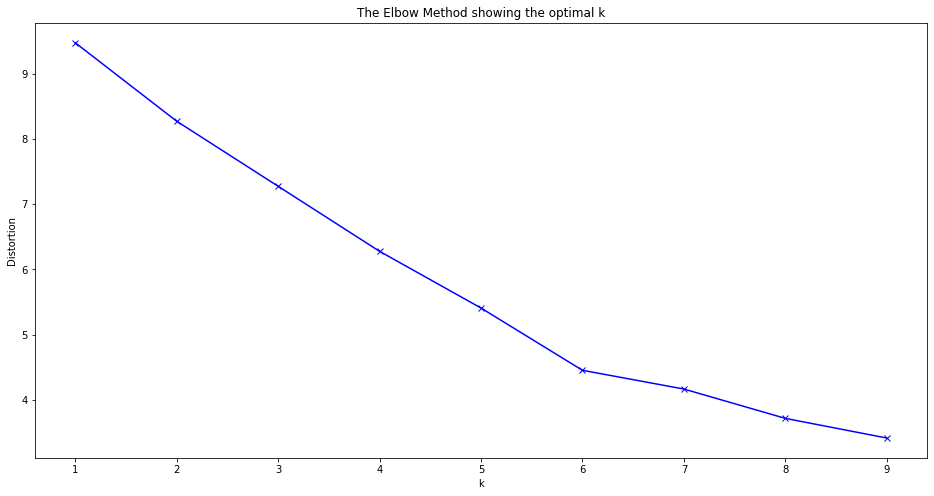

In [17]:

# Find the best k
clustering = neighborhood_grouped.drop('Neighborhood', 1)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(clustering)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()



In [97]:
# set number of clusters
kclusters = 6

venue_clustering = neighborhood_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1,
       0, 5, 1, 1, 1, 1, 1, 1, 4, 1, 1], dtype=int32)

In [100]:

#wiki_df.drop([1], inplace=True)

wiki_df['Cluster Labels'] = kmeans.labels_

# merge wiki_df with neighborhoods_venues_sorted
calgary_area_venue = wiki_df.join(top10_venues.set_index('Neighborhood'), on='Neighborhood')

calgary_area_venue.reset_index(inplace=True)
calgary_area_venue.head()

,index,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,145,T2W,Calgary,"Braeside, Cedarbrae, Woodbine",50.9604,-114.1001,1,Gym,Gas Station,Convenience Store,Pub,Pizza Place,Pharmacy,Ice Cream Shop,Hockey Rink,Coffee Shop,Deli / Bodega
1,73,T2L,Calgary,"Brentwood, Collingwood, Nose Hill",51.0917,-114.1127,2,Electronics Store,Yoga Studio,Convenience Store,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run
2,28,T2E,Calgary,"Bridgeland, Greenview, Zoo, YYC",51.0632,-114.0614,1,Bank,Fast Food Restaurant,Sandwich Place,Falafel Restaurant,Chinese Restaurant,Dim Sum Restaurant,Noodle House,Pharmacy,Indian Restaurant,Poke Place
3,100,T2P,Calgary,"City Centre, Calgary Tower",51.0472,-114.0802,1,Mediterranean Restaurant,Bakery,Pub,Restaurant,Coffee Shop,Sushi Restaurant,Bar,Moroccan Restaurant,Nightclub,Camera Store
4,109,T2R,Calgary,"Connaught, West Victoria Park",51.0426,-114.0791,1,Bar,Mediterranean Restaurant,Coffee Shop,French Restaurant,Brewery,Moroccan Restaurant,Nightclub,Chinese Restaurant,Scandinavian Restaurant,Camera Store


In [101]:
# Use folium library to visualize neighborhoods in Calgary

address = "Calgary, AB"
geolocator = Nominatim(user_agent="calgary_explorer")
location = geolocator.geocode(address)
Cal_latitude = location.latitude
Cal_longitude = location.longitude

c_map = folium.Map(location=[Cal_latitude, Cal_longitude], zoom_start=10)

# df.dtypes change data type to float for latitude and longitude
calgary_area_venue[['Latitude', 'Longitude']] = calgary_area_venue[['Latitude', 'Longitude']].astype(str).astype(float)

# Visualizing all the Neighbourhoods of the above data frame
for lat, lng, neighbourhood in zip(calgary_area_venue['Latitude'],calgary_area_venue['Longitude'], calgary_area_venue['Neighborhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    
    #print(lat, lng, label)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(c_map)

c_map

In [102]:

# Add the venue cluster labels to calgary map
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, nei, cluster in zip(
    calgary_area_venue['Latitude'], 
    calgary_area_venue['Longitude'], 
    calgary_area_venue['Neighborhood'], 
    calgary_area_venue['Cluster Labels']):
    
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(c_map)
       
c_map

### Examine each cluster



In [72]:
# Cluster label = 0
cluster0 = calgary_area_venue.loc[calgary_area_venue['Cluster Labels'] == 0, calgary_area_venue.columns[[3] + list(range(5, calgary_area_venue.shape[1]))]]
cluster0


,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,"Highfield, Burns Industrial",-114.0631,0,American Restaurant,Falafel Restaurant,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Donut Shop
22,Northeast Calgary,-114.0019,0,American Restaurant,Hotel,Falafel Restaurant,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run


In [71]:
# Cluster label = 1
cluster1 = calgary_area_venue.loc[calgary_area_venue['Cluster Labels'] == 1, calgary_area_venue.columns[[3] + list(range(5, calgary_area_venue.shape[1]))]]
cluster1

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Braeside, Cedarbrae, Woodbine",-114.100100,1,Gym,Gas Station,Convenience Store,Pub,Pizza Place,Pharmacy,Ice Cream Shop,Hockey Rink,Coffee Shop,Deli / Bodega
2,"Bridgeland, Greenview, Zoo, YYC",-114.061400,1,Bank,Fast Food Restaurant,Sandwich Place,Falafel Restaurant,Chinese Restaurant,Dim Sum Restaurant,Noodle House,Pharmacy,Indian Restaurant,Poke Place
3,"City Centre, Calgary Tower",-114.080200,1,Mediterranean Restaurant,Bakery,Pub,Restaurant,Coffee Shop,Sushi Restaurant,Bar,Moroccan Restaurant,Nightclub,Camera Store
4,"Connaught, West Victoria Park",-114.079100,1,Bar,Mediterranean Restaurant,Coffee Shop,French Restaurant,Brewery,Moroccan Restaurant,Nightclub,Chinese Restaurant,Scandinavian Restaurant,Camera Store
5,"Cranston, Auburn Bay, Mahogany",-113.989200,1,Cosmetics Shop,Pizza Place,Liquor Store,Factory,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
6,"Dalhousie, Edgemont, Hamptons, Hidden Valley",-114.143158,1,Convenience Store,Asian Restaurant,Gas Station,Café,Falafel Restaurant,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant
7,"Discovery Ridge, Signal Hill, West Springs, Ch...",-114.181500,1,Bar,Vietnamese Restaurant,Convenience Store,Pizza Place,Gas Station,Yoga Studio,Dry Cleaner,Donut Shop,Dog Run,Diner
8,"Douglas Glen, McKenzie Lake, Copperfield, East...",-113.987300,1,Park,Playground,Dry Cleaner,Food Truck,Bar,Bus Stop,Asian Restaurant,Curling Ice,Dessert Shop,Department Store
9,"Elbow Park, Britannia, Parkhill, Mission",-114.081200,1,Coffee Shop,Japanese Restaurant,Kids Store,Bus Station,Yoga Studio,Falafel Restaurant,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant
11,"Hawkwood, Arbour Lake, Citadel, Ranchlands, Ro...",-114.179600,1,Shop & Service,Pizza Place,Pub,Construction & Landscaping,Cosmetics Shop,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant


In [75]:
cluster1['1st Most Common Venue'].value_counts()

Convenience Store           3
Bar                         2
Coffee Shop                 2
Hotel                       2
Pizza Place                 2
Park                        2
Bank                        2
Mediterranean Restaurant    1
Gym                         1
Shop & Service              1
Indian Restaurant           1
Burger Joint                1
Wine Shop                   1
Vietnamese Restaurant       1
Arts & Crafts Store         1
Grocery Store               1
Cosmetics Shop              1
American Restaurant         1
Name: 1st Most Common Venue, dtype: int64

In [34]:
cluster1.shape

(26, 13)

In [103]:
# Cluster label = 2
cluster2 = calgary_area_venue.loc[calgary_area_venue['Cluster Labels'] == 2, calgary_area_venue.columns[[3] + list(range(5, calgary_area_venue.shape[1]))]]
cluster2.head()

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Brentwood, Collingwood, Nose Hill",-114.1127,2,Electronics Store,Yoga Studio,Convenience Store,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run


In [104]:
# Cluster label = 3
cluster3 = calgary_area_venue.loc[calgary_area_venue['Cluster Labels'] == 3, calgary_area_venue.columns[[3] + list(range(5, calgary_area_venue.shape[1]))]]
cluster3.head()

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,"Midnapore, Sundance",-114.0674,3,Mobile Phone Shop,Yoga Studio,Convenience Store,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run


In [105]:
# Cluster label = 4
cluster4 = calgary_area_venue.loc[calgary_area_venue['Cluster Labels'] == 4, calgary_area_venue.columns[[3] + list(range(5, calgary_area_venue.shape[1]))]]
cluster4.head()

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,"Forest Lawn, Dover, Erin Woods",-113.9786,4,Smoke Shop,Bar,Convenience Store,Falafel Restaurant,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
30,Symons Valley,-114.1333,4,Convenience Store,Yoga Studio,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Donut Shop


In [106]:
# Cluster label = 5
cluster5 = calgary_area_venue.loc[calgary_area_venue['Cluster Labels'] == 5, calgary_area_venue.columns[[3] + list(range(5, calgary_area_venue.shape[1]))]]
cluster5.head()

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Northwest Calgary,-114.2695,5,Flea Market,Yoga Studio,Falafel Restaurant,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run


### 3. Explore property values for each Neighborhood in Calgary

### Collecting and cleaning data

First, a data set provided by City of Calgary was imported and only necessary information such as assessed values for the property, type of property, community name, latitude and longitude were collected. As this project focuses on only residential properties, farm lands, commercial areas were removed. Also the rows were dropped where there were no property values or location information available. After creating a table with property values for each residential property, the averages of the values by the neighborhoods were calculated.

In [45]:
path = 'https://jupyterlab-3-labs-prod-jupyterlab-us-east-3.labs.cognitiveclass.ai/user/mihoely/doc/tree/labs/DS0701EN/2021_Assessed_Property_Values.csv'
raw_df = pd.read_csv('2021_Assessed_Property_Values.csv')
raw_df.shape

(553562, 22)

In [46]:
#Collect and clean all necessary data
property_value=raw_df[['ADDRESS', 
                       'ASSESSED_VALUE',
                       'ASSESSMENT_CLASS_DESCRIPTION',
                       'COMM_NAME', 'LAND_USE_DESIGNATION',
                       'LATITUDE',
                       'LONGITUDE']].copy()

property_value = property_value[property_value.ASSESSMENT_CLASS_DESCRIPTION == 'Residential'] # Remove commercial and industrial property
property_value = property_value[property_value.ASSESSED_VALUE != 0.0] # Remove the rows has no property values available

# Remove rows if there are NA value 
property_value.dropna(subset=['ASSESSED_VALUE',
                              'ASSESSMENT_CLASS_DESCRIPTION',
                              'COMM_NAME', 'LAND_USE_DESIGNATION',
                              'LATITUDE'], inplace=True)
property_value.shape
property_value.head()

# only use residential and Multi-Residential property for this analysis
# According to Land use districts of Calgary LAND_USE_DESIGNATION indicates type of property. 
# Look for 'Land' start with 'R' for residentail and 'M' for multi-residential property.
residential_property_value = property_value[property_value['LAND_USE_DESIGNATION'].str.startswith('R' or 'M')]
residential_property_value.head()


,ADDRESS,ASSESSED_VALUE,ASSESSMENT_CLASS_DESCRIPTION,COMM_NAME,LAND_USE_DESIGNATION,LATITUDE,LONGITUDE
149,4607 88 AV NE,447000.0,Residential,SADDLE RIDGE,"R-G,C-N1,M-X2",51.131562,-113.967843
156,4908 84 AV NE,447000.0,Residential,SADDLE RIDGE,"R-G,S-SPR",51.129820,-113.963482
159,4612 84 AV NE,1650000.0,Residential,SADDLE RIDGE,"R-G,S-SPR",51.129822,-113.967844
170,6827 89 AV NE,3310000.0,Residential,SADDLE RIDGE,"R-G,R-Gm",51.133209,-113.936082
171,6819 89 AV NE,3120000.0,Residential,SADDLE RIDGE,R-G,51.133208,-113.937442


In [47]:
# Average the property values by the name of neighborhoods and change the column name 'ASSESSED_VALUE' to 'Average_ASSESSED_VALUE'

average_value = residential_property_value.groupby('COMM_NAME').mean()
average_value.rename(columns = {'ASSESSED_VALUE':'Average_ASSESSED_VALUE'}, inplace = True)
average_value

,Average_ASSESSED_VALUE,LATITUDE,LONGITUDE
COMM_NAME,,,
ABBEYDALE,280219.101124,51.058959,-113.929288
ACADIA,409829.862557,50.970638,-114.053825
ALBERT PARK/RADISSON HEIGHTS,332237.421384,51.043208,-113.991105
ALTADORE,877633.991895,51.014911,-114.104051
AMBLETON,100850.000000,51.184674,-114.108960
...,...,...,...
WINSTON HEIGHTS/MOUNTVIEW,534309.440559,51.074130,-114.050541
WOLF WILLOW,282575.342466,50.875524,-114.002306
WOODBINE,455997.010960,50.941762,-114.128436


In [48]:
# Round up the 'Average_ASSESSED_VALUE' and add new column 'Roundup_ASSESSED_VALUE'
average_value['Roundup_Average_Value'] = average_value['Average_ASSESSED_VALUE'].apply(np.ceil) 

# Drop 'Average_ASSESSED_VALUE'
average_value = average_value.drop('Average_ASSESSED_VALUE', 1)
average_value.head()

,LATITUDE,LONGITUDE,Roundup_Average_Value
COMM_NAME,,,
ABBEYDALE,51.058959,-113.929288,280220.0
ACADIA,50.970638,-114.053825,409830.0
ALBERT PARK/RADISSON HEIGHTS,51.043208,-113.991105,332238.0
ALTADORE,51.014911,-114.104051,877634.0
AMBLETON,51.184674,-114.108960,100850.0


### Histogram and onehot encoding
A histogram is a simple way to display the data value in bars to show the frequency of data items in equal interval size and makes it easier to see the dispersion and central tendency. After a table with property values of neighborhood was created, a histogram was used to show a frequency of distribution in different ranges. Each range was defined as 'Low -1', 'Mid-1', 'Mid-2', 'High-1' and 'High-2' based on the values of property. As those are categorical data, one hot encoding was used to transform to numeric data as a preparation of kmeans clustering. 

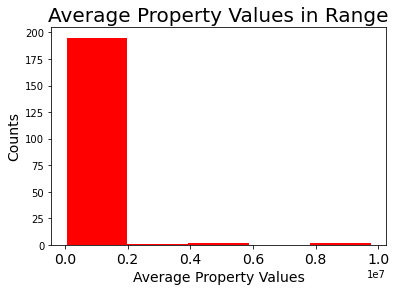

In [49]:
# Use histogram and examine the frequency of average property values in different ranges

plt.hist(average_value['Roundup_Average_Value'], bins=5, facecolor='red')
plt.title("Average Property Values in Range",fontsize= 20)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Average Property Values', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()
plt.show()

In [50]:
#define the range according to the histogram shows.
level = []
for i in range(0,len(average_value)):
    if (average_value['Roundup_Average_Value'][i] < 200000):
        level.append("Low-1")
    elif (average_value['Roundup_Average_Value'][i] >= 200000 and average_value['Roundup_Average_Value'][i] < 400000):
        level.append("Mid-1")
    elif (average_value['Roundup_Average_Value'][i] >= 400000 and average_value['Roundup_Average_Value'][i] < 600000):
        level.append("Mid-2")
    elif (average_value['Roundup_Average_Value'][i] >= 600000 and average_value['Roundup_Average_Value'][i] < 800000):
        level.append("High-1")
    else:
        level.append("High-2")   
        
average_value['Value_level_label'] = level
average_value.head(10)

,LATITUDE,LONGITUDE,Roundup_Average_Value,Value_level_label
COMM_NAME,,,,
ABBEYDALE,51.058959,-113.929288,280220.0,Mid-1
ACADIA,50.970638,-114.053825,409830.0,Mid-2
ALBERT PARK/RADISSON HEIGHTS,51.043208,-113.991105,332238.0,Mid-1
ALTADORE,51.014911,-114.104051,877634.0,High-2
AMBLETON,51.184674,-114.108960,100850.0,Low-1
APPLEWOOD PARK,51.045039,-113.928229,345952.0,Mid-1
ARBOUR LAKE,51.136006,-114.201109,518080.0,Mid-2
ASPEN WOODS,51.044836,-114.208418,977167.0,High-2
AUBURN BAY,50.892268,-113.956901,517433.0,Mid-2


In [51]:
# one hot encoding
value_onehot = pd.get_dummies(average_value[['Value_level_label']], prefix="", prefix_sep="")
value_onehot.head()

,High-1,High-2,Low-1,Mid-1,Mid-2
COMM_NAME,,,,,
ABBEYDALE,0,0,0,1,0
ACADIA,0,0,0,0,1
ALBERT PARK/RADISSON HEIGHTS,0,0,0,1,0
ALTADORE,0,1,0,0,0
AMBLETON,0,0,1,0,0


### Clustering with Kmeans and visualization
The residential properties were divided into 5 different groups based on the values. Therefore 5 clusters were created and showns on a map with the cluster labels. 

In [57]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(value_onehot)

# cluster labels
kmeans_label = kmeans.labels_

In [58]:
average_value.insert(0, 'Cluster Labels', kmeans_label)
average_value

,Cluster Labels,COMM_NAME,LATITUDE,LONGITUDE,Roundup_Average_Value,Value_level_label
0,2,ABBEYDALE,51.058959,-113.929288,280220.0,Mid-1
1,1,ACADIA,50.970638,-114.053825,409830.0,Mid-2
2,2,ALBERT PARK/RADISSON HEIGHTS,51.043208,-113.991105,332238.0,Mid-1
3,3,ALTADORE,51.014911,-114.104051,877634.0,High-2
4,4,AMBLETON,51.184674,-114.108960,100850.0,Low-1
...,...,...,...,...,...,...
195,1,WINSTON HEIGHTS/MOUNTVIEW,51.074130,-114.050541,534310.0,Mid-2
196,2,WOLF WILLOW,50.875524,-114.002306,282576.0,Mid-1
197,1,WOODBINE,50.941762,-114.128436,455998.0,Mid-2
198,1,WOODLANDS,50.940949,-114.110869,456386.0,Mid-2


In [59]:
average_value.reset_index(inplace = True)
average_value.head()

,index,Cluster Labels,COMM_NAME,LATITUDE,LONGITUDE,Roundup_Average_Value,Value_level_label
0,0,2,ABBEYDALE,51.058959,-113.929288,280220.0,Mid-1
1,1,1,ACADIA,50.970638,-114.053825,409830.0,Mid-2
2,2,2,ALBERT PARK/RADISSON HEIGHTS,51.043208,-113.991105,332238.0,Mid-1
3,3,3,ALTADORE,51.014911,-114.104051,877634.0,High-2
4,4,4,AMBLETON,51.184674,-114.108960,100850.0,Low-1


In [107]:
# Use folium library to visualize neighborhoods in Calgary with property value cluster labels
address = "Calgary, AB"
geolocator = Nominatim(user_agent="calgary_explorer")
location = geolocator.geocode(address)
Cal_latitude = location.latitude
Cal_longitude = location.longitude

map_clusters2 = folium.Map(location=[Cal_latitude, Cal_longitude], zoom_start=11)
kclusters = 5
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighborhood, level, cluster in zip( 
        average_value['LATITUDE'], 
        average_value['LONGITUDE'],
        average_value['COMM_NAME'],
        average_value['Value_level_label'],
        average_value['Cluster Labels']):
    
    
    label = folium.Popup(str(neighborhood) +','+ 'Value Level'+ str(level), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
    
map_clusters2



### Examine each cluster

In [77]:
#Cluster label = 0
cluster0 = average_value.loc[average_value['Cluster Labels'] == 0, average_value.columns[[1,2] + [5,6]]]
cluster0_sorted = cluster0.sort_values(['Roundup_Average_Value'], ascending=False, axis=0)
cluster0_sorted

,Cluster Labels,COMM_NAME,Roundup_Average_Value,Value_level_label
122,0,PARKDALE,791785.0,High-1
94,0,LOWER MOUNT ROYAL,774584.0,High-1
171,0,SPRINGBANK HILL,756386.0,High-1
137,0,RESIDUAL WARD 1 - SUB AREA 1L,750725.0,High-1
125,0,PATTERSON,749448.0,High-1
188,0,WEST HILLHURST,746163.0,High-1
168,0,SOUTH CALGARY,745438.0,High-1
81,0,HILLHURST,744298.0,High-1
31,0,CHRISTIE PARK,743497.0,High-1
91,0,LAKEVIEW,731536.0,High-1


In [83]:
cluster0.shape

(35, 4)

In [85]:
#Cluster label = 1
cluster1 = average_value.loc[average_value['Cluster Labels'] == 1, average_value.columns[[1,2] + [5,6]]]
cluster1_sorted = cluster1.sort_values(['Roundup_Average_Value'], ascending=False, axis=0)
cluster1_sorted

,COMM_NAME,Cluster Labels,Roundup_Average_Value,Value_level_label
136,RENFREW,1,599622.0,Mid-2
87,KILLARNEY/GLENGARRY,1,596366.0,Mid-2
174,STRATHCONA PARK,1,593896.0,Mid-2
10,BANKVIEW,1,588261.0,Mid-2
22,CAMBRIAN HEIGHTS,1,587430.0,Mid-2
...,...,...,...,...
105,MCKENZIE TOWNE,1,403879.0,Mid-2
49,DEER RUN,1,403458.0,Mid-2
37,COPPERFIELD,1,402622.0,Mid-2
17,BRAESIDE,1,402364.0,Mid-2


In [84]:
cluster1.shape

(26, 13)

In [86]:
#Cluster label = 2
cluster2 = average_value.loc[average_value['Cluster Labels'] == 2, average_value.columns[[1,2] + [5,6]]]
cluster2_sorted = cluster2.sort_values(['Roundup_Average_Value'], ascending=False, axis=0)
cluster2_sorted

,Cluster Labels,COMM_NAME,Roundup_Average_Value,Value_level_label
103,2,MAYLAND HEIGHTS,395972.0,Mid-1
41,2,COUNTRY HILLS,395423.0,Mid-1
143,2,RIVERBEND,393479.0,Mid-1
75,2,HARVEST HILLS,391976.0,Mid-1
15,2,BONAVISTA DOWNS,391787.0,Mid-1
167,2,SOMERSET,391680.0,Mid-1
62,2,FAIRVIEW,391654.0,Mid-1
133,2,RANCHLANDS,390830.0,Mid-1
20,2,BRIDLEWOOD,385109.0,Mid-1
109,2,MILLRISE,383831.0,Mid-1


In [87]:
cluster2.shape

(48, 4)

In [88]:
#Cluster label = 3
cluster3 = average_value.loc[average_value['Cluster Labels'] == 3, average_value.columns[[1,2] + [5,6]]]
cluster3_sorted = cluster3.sort_values(['Roundup_Average_Value'], ascending=False, axis=0)
cluster3_sorted

,Cluster Labels,COMM_NAME,Roundup_Average_Value,Value_level_label
134,3,RED CARPET/MOUNTVIEW MOBILE PARK,9764000.0,High-2
33,3,CITYSCAPE,8645000.0,High-2
140,3,RESIDUAL WARD 13 - SUB AREA 13M,5080000.0,High-2
107,3,MEDICINE HILL,3950000.0,High-2
13,3,BEL-AIRE,2018688.0,High-2
21,3,BRITANNIA,1935659.0,High-2
54,3,EAGLE RIDGE,1750521.0,High-2
183,3,UPPER MOUNT ROYAL,1582976.0,High-2
142,3,RIDEAU PARK,1509092.0,High-2
56,3,ELBOW PARK,1443362.0,High-2


In [89]:
cluster3.shape

(28, 4)

In [90]:
#Cluster label = 4
cluster4 = average_value.loc[average_value['Cluster Labels'] == 4, average_value.columns[[1,2] + [5,6]]]
cluster4_sorted = cluster4.sort_values(['Roundup_Average_Value'], ascending=False, axis=0)
cluster4_sorted

,Cluster Labels,COMM_NAME,Roundup_Average_Value,Value_level_label
127,4,PINE CREEK,199897.0,Low-1
4,4,AMBLETON,100850.0,Low-1
82,4,HOMESTEAD,50713.0,Low-1


In [91]:
cluster4.shape

(3, 4)